# Classification of SUDORS vs. Non-SUDORS Autopsy Summaries with Logistic Regression

In [1]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
narr_df = pd.read_feather(r'C:/Users/DC20B46/Documents/narratives_all_2019-2021h1_v2.feather')

In [25]:
narr_df.shape

(17523, 4)

In [26]:
narr_df.Year.value_counts()

2021    6676
2020    5891
2019    4956
Name: Year, dtype: int64

In [3]:
narr_df.head(3)

,DID,forensic_center,Year,case,doc_clean,narr,interp,circ,has_narr,has_interp,has_circ,full_narr,full_narr_len
0,2019022033,W,2019,0,office of the medical examiner west tennessee ...,narrative summary date of death type of death ...,summary and interpretation the decedent was a ...,,1,1,0,narrative summary date of death type of death ...,2191
1,2019004303,W,2019,0,office of the medical examiner west tennessee ...,summary state number: 19-79-0106 case number: ...,summary and interpretation: this 41 year old m...,,1,1,0,summary state number: 19-79-0106 case number: ...,2080
2,2019018448,W,2019,0,office of the medical examiner west tennessee ...,narrative summary state number: 19-79-0818 cas...,summary and interpretation the decedent was an...,,1,1,0,narrative summary state number: 19-79-0818 cas...,3576


In [4]:
# Focus on full_narr, case, DID, and Year only:

narr_df = narr_df[['DID', 'full_narr', 'case', 'Year']]
narr_df.head()

,DID,full_narr,case,Year
0,2019022033,narrative summary date of death type of death ...,0,2019
1,2019004303,summary state number: 19-79-0106 case number: ...,0,2019
2,2019018448,narrative summary state number: 19-79-0818 cas...,0,2019
3,2021036263,narrative summary reportedly this 38 year-old ...,0,2021
4,2021047621,narrative summary the decedent was reported to...,0,2021


### SUDORS Autopsy Class Distribution

C:\Users\DC20B46\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


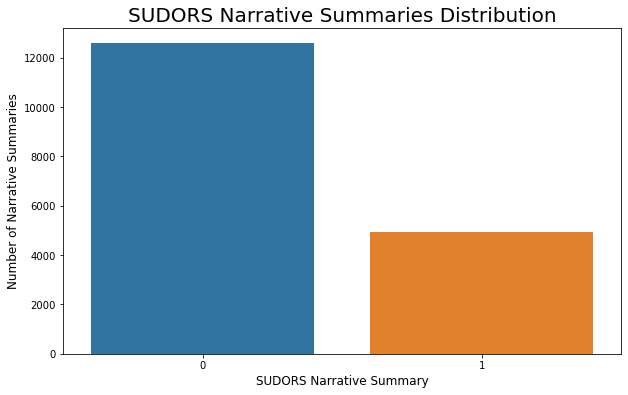

In [6]:
od_count = narr_df['case'].value_counts()
od_count = od_count.sort_index()

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(od_count.index, od_count.values)
plt.title("SUDORS Narrative Summaries Distribution",fontsize = 20)
plt.ylabel('Number of Narrative Summaries', fontsize = 12)
plt.xlabel('SUDORS Narrative Summary', fontsize = 12);

In [7]:
od_count

0    12588
1     4935
Name: case, dtype: int64

In [8]:
# baseline accuracy based on the number of SUDORS narrative summaries compared to the total number of narrative summaries
print((12588/(12588+4935)))

0.7183701420989557


### train-test split

In [9]:
train, test = train_test_split(narr_df, test_size = 0.2, stratify = narr_df['case'], random_state = 42)

## Text Preprocessing

### First, remove all non-letter characters, punctuations, and make sure all letters are in lower-cases. Later we will also evaluate the effect of removing stopwords and stemming/lemmatization.

In [10]:
punct = set(string.punctuation)

In [11]:
def text_prep(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    return [word for word in punc_removed.split()]

### binary feature representation, no stopwords removal or stemming, all unigrams

In [12]:
start_time = time.time()
cv= CountVectorizer(binary=True, analyzer = text_prep, min_df = 10, max_df = 0.95)
cv.fit_transform(train['full_narr'].values)
train_feature_set=cv.transform(train['full_narr'].values)
test_feature_set=cv.transform(test['full_narr'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.14  mins


In [13]:
train_feature_set.shape[1] # size of the vocabulary left in our corpus

9518

In [14]:
cv.vocabulary_['decedent']

2157

### Fit Logistic Regression Model

In [16]:
y_train = train['case'].values
y_test = test['case'].values

In [17]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  0.05  mins


In [23]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ", round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test, y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Accuracy:  0.922
F1:  0.861
Precision:  0.857
Recall:  0.865
ROC_AUC:  0.904


C:\Users\DC20B46\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


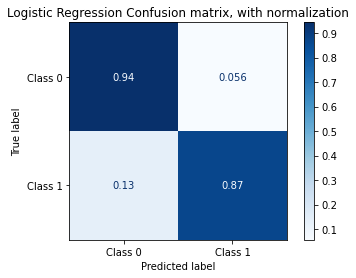

In [24]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

In [27]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  aaron Score:  0.4693119282745139
Feature:  ab Score:  -0.18951602127390746
Feature:  abandoned Score:  -0.045845632030012434
Feature:  abbi Score:  -0.36283551760592303
Feature:  abbott Score:  -0.11033170140056338
Feature:  abby Score:  -0.019476872068144403
Feature:  abcgke Score:  -0.009008692580191779
Feature:  abdomen Score:  -0.07679916216099074
Feature:  abdominal Score:  -0.07191839592797666
Feature:  ability Score:  -0.18519545149047598


In [28]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

### Top words for the positive class (SUDORS narrative summaries):

In [29]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['intoxication', 'accident', 'toxicity', 'abs', 'effects', 'panel', 'narrative', 'cid', 'injected', 'material']


C:\Users\DC20B46\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


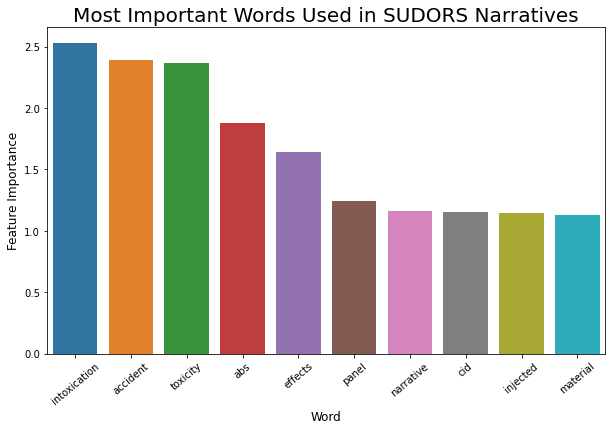

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used in SUDORS Narratives",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

#### Check all the narrative summaries that contain the word ‘overdose’ and see how many of them are in the SUDORS class:

In [33]:
sub_poi = train.loc[train.full_narr.str.contains('overdose')]
round(sub_poi.case.mean(),3)

0.671

### Top words for the negative class (non-SUDORS narrative summaries):

In [35]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['inms', 'natural', 'lnms', 'dod', 'october', 'phenylpropanolamine', 'believes', 'manner', 'november', 'gunshot']


C:\Users\DC20B46\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


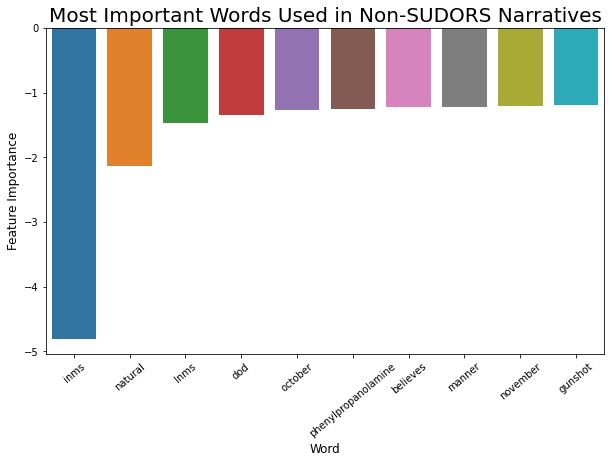

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used in Non-SUDORS Narratives",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

## Improvement Strategies

### After we establish the first model, examine couple of ideas to see if our model can be further improved.

### 1: Decrease the probability cutoff threshold
#### To reduce False Negatives, one intuition is to lower the cutoff threshold (default at 0.5). This would increase the recall but also decrease the precision. Therefore, we need to check if this would improve the overall F1 score:

In [58]:
pred_proba_df = pd.DataFrame(lr.predict_proba(test_feature_set))
threshold_list = [0.2,0.3,0.4,0.45,0.5, 0.6, 0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_AUC = round(metrics.roc_auc_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('AUC: {}'.format(test_AUC))
    test_f1 = round(metrics.f1_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('F1: {}'.format(test_f1))
    test_recall = round(metrics.recall_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Recall: {}'.format(test_recall))
    test_precision = round(metrics.precision_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Precision: {}'.format(test_precision))


******** For i = 0.2 ******
AUC: 0.921
F1: 0.844
Recall: 0.973
Precision: 0.745

******** For i = 0.3 ******
AUC: 0.924
F1: 0.862
Recall: 0.943
Precision: 0.794

******** For i = 0.4 ******
AUC: 0.912
F1: 0.859
Recall: 0.899
Precision: 0.824

******** For i = 0.45 ******
AUC: 0.901
F1: 0.853
Recall: 0.868
Precision: 0.838

******** For i = 0.5 ******
AUC: 0.886
F1: 0.839
Recall: 0.832
Precision: 0.846

******** For i = 0.6 ******
AUC: 0.847
F1: 0.798
Recall: 0.736
Precision: 0.872

******** For i = 0.7 ******
AUC: 0.793
F1: 0.728
Recall: 0.614
Precision: 0.894


#### Best F1 score for i = 0.3

### 2: Oversample Class 1 or undersample Class 0

In [48]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(train_feature_set,y_train)
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_under,y_under)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test,y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test,y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Time takes to train model and make predictions:  28.6  mins
Accuracy:  0.916
F1:  0.861
Precision:  0.804
Recall:  0.925
ROC_AUC:  0.918


In [47]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_feature_set,y_train)
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_over,y_over)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test,y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test,y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Time takes to train model and make predictions:  28.54  mins
Accuracy:  0.923
F1:  0.867
Precision:  0.842
Recall:  0.893
ROC_AUC:  0.914


####  F1 score does not improve from oversampling or undersampling

### 3: Remove stopwords and stemming

In [49]:
sw = set(stopwords.words("english"))
ps = PorterStemmer()

In [50]:
def text_prep_stop_stem(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    return [ps.stem(word) for word in punc_removed.split() if not word in sw]
    #return [word for word in punc_removed.split() if not word in sw]

In [52]:
start_time = time.time()
cv= CountVectorizer(binary=True, analyzer = text_prep_stop_stem, min_df = 10, max_df = 0.95)
cv.fit_transform(train['full_narr'].values)
train_feature_set=cv.transform(train['full_narr'].values)
test_feature_set=cv.transform(test['full_narr'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  1.72  mins


In [53]:
train_feature_set.shape[1]   # previously the size of the vocabulary was 9,518

7621

In [54]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test,y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test,y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Time takes to train model and make predictions:  0.02  mins
Accuracy:  0.92
F1:  0.859
Precision:  0.854
Recall:  0.864
ROC_AUC:  0.903


#### F1 score and accuracy actually decreased by a small amount

### 4: Use TF-IDF instead of binary representation

In [56]:
start_time = time.time()
tfidf_v=TfidfVectorizer(use_idf=True, analyzer = text_prep, min_df = 10, max_df = 0.95)
tfidf_v.fit_transform(train['full_narr'].values)
train_feature_set=tfidf_v.transform(train['full_narr'].values)
test_feature_set=tfidf_v.transform(test['full_narr'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.14  mins


In [57]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test,y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test,y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Time takes to train model and make predictions:  0.01  mins
Accuracy:  0.91
F1:  0.839
Precision:  0.846
Recall:  0.832
ROC_AUC:  0.886


### 5: Include both unigrams and bigrams as features

In [59]:
start_time = time.time()
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(1,2))
cv.fit_transform(train['full_narr'].values)
train_feature_set=cv.transform(train['full_narr'].values)
test_feature_set=cv.transform(test['full_narr'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.21  mins


In [60]:
train_feature_set.shape[1] # After we take both unigrams and bigrams (sequence of two words) into consideration, 
# we first see an increase in vocabulary size:

52731

In [94]:
# cv.vocabulary_

In [63]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test,y_pred),3))
print("Recall: ", round(metrics.recall_score(y_test,y_pred),3))
print("ROC_AUC: ", round(metrics.roc_auc_score(y_test, y_pred),3))

Time takes to train model and make predictions:  0.05  mins
Accuracy:  0.947
F1:  0.906
Precision:  0.902
Recall:  0.911
ROC_AUC:  0.936


C:\Users\DC20B46\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


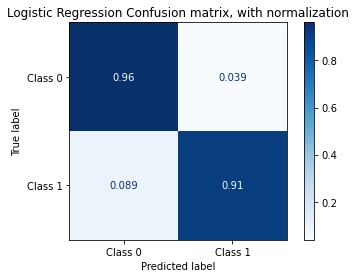

In [64]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

#### After fitting this model, we see improvements in most metrics, especially in F1, accuracy, and AUC score.

In [65]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  00 Score:  0.06057186519778942
Feature:  00 00 Score:  -0.06257933763571748
Feature:  00 001 Score:  0.027876662856016837
Feature:  00 09 Score:  -0.004168052389549659
Feature:  00 70 Score:  0.027834871251063018
Feature:  00 am Score:  -0.07054791215090621
Feature:  00 and Score:  0.0833432934244404
Feature:  00 autopsy Score:  0.00232079950685073
Feature:  00 by Score:  0.010498012951623824
Feature:  00 complete Score:  0.04007588341932751


#### The new top 10 features for both SUDORS and non-SUDORS narrative summaries again

In [66]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['toxicity', 'accident', 'intoxication', 'toxic effects', 'accident the', 'fentanyl', 'abs', 'nms abs', 'narrative', 'overdose']


In [67]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['natural', 'is natural', 'inms', 'inms nms', '2021', 'postmortem toxicological', 'of inms', 'mec21', 'gsw', 'of patient']


C:\Users\DC20B46\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


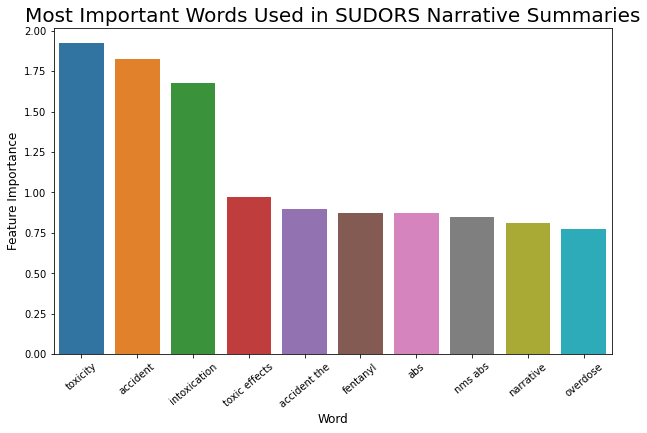

In [68]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used in SUDORS Narrative Summaries",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

C:\Users\DC20B46\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


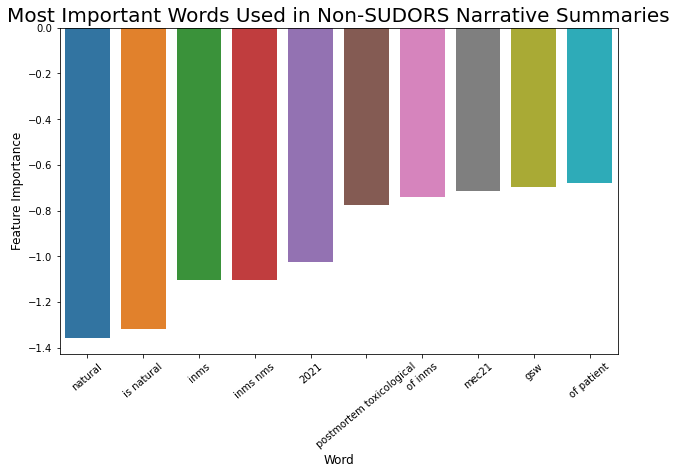

In [69]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used in Non-SUDORS Narrative Summaries",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);